<a href="https://colab.research.google.com/github/ttogle918/ds-section4-sprint3/blob/master/N434/N434a_GAN_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src='https://user-images.githubusercontent.com/6457691/90080969-0f758d00-dd47-11ea-8191-fa12fd2054a7.png' width = '200' align = 'right'>

## *DATA SCIENCE / SECTION 4 / SPRINT 3 / Assignment 4*

## 문제1.

아래는 Lecture Note에 있는 생성자 생성 함수입니다. Conv2DTranspose가 아닌 Upsampling을 사용하는 구조로 변경을 하였고, Seqeuntial API가 아닌 함수형 API를 사용하는 방식으로 변경을 하였습니다. 이때, Upsampling 층을 통과한 후의 이미지 shape에 대해 적어주세요.

Upsampling + Conv2D가 어떻게 Conv2DTranspose를 대체할 수 있는지, 각각의 역할이 무엇인지에 대해 찾아주세요!

Upsampling :  
- output의 크기가 input보다 커지게 하는 방법
- 활용 예시 : semantic semantation, U-net 등 크기를 되돌리는 행위가 필요할 때, 모양이 맞아야 할 대

Conv2D : 
- input 데이터에 filter map을 연산하여 나타난다.
- Conv연산은 output 크기가 input 크기보다 작아진다.

Conv2DTranspose : 
- Unsampling 기법 ( input 크기 < output 크기가 되도록 하는 기법 )의 일종
- Deconvolution, Upconvolution, Fractionally strided convolution, Backward strided convolution이라고 불리기도 한다.(여기서 Deconvolution과는 계산 방법이 다르다)
- Convolution 계산과정을 역으로 한다.
- input값 원소 * 필터 = output ( 겹치는 부분은 합으로 한다 )

Deconvolution : 
- 역 연산을 통해서 input을 재현하는 것이 목적이다.
- Convolution 연산할 때 사용한 kernel과 output을 알고 있어야 한다.

- 문제1-1. 첫번째 Upsampling와 Conv2D 레이어를 통과한 후의 shape으로 알맞은 것은?
- 문제1-2. 첫번째 Conv2DTranspose 레이어르 통과한 후의 shape으로 알맞은 것은?

batch를 의미하는 None은 제외하고 [30, 30, 30] 형태로 적어주세요

In [1]:
import tensorflow as tf

# 코드 문제
```
def make_generator_model():
    generator_input = tf.keras.layers.Input(shape=(100,), name='generator_input')
    x = generator_input
    x = tf.keras.layers.Dense(7*7*256, use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Reshape((7,7,256))(x)
    
    x = tf.keras.layers.UpSampling2D()(x)
    x = tf.keras.layers.Conv2D(128, 5, strides=1, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    
    x = tf.keras.layers.UpSampling2D()(x)
    x = tf.keras.layers.Conv2D(64, 5, strides=1, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    
    x = tf.keras.layers.Conv2DTranspose(64, 5, strides=1, padding='same', use_bias=False)(x)
    x = tf.keras.layers.Conv2DTranspose(1, 5, strides=1, padding='same', use_bias=False, activation='tanh')(x)
    generator_output = x
    return tf.keras.models.Model(generator_input, generator_output)
```



## 문제2
AutoEncoder에서 사용했던 구글 QuickDraw 데이터셋을 다시 활용해보겠습니다.

In [2]:
import json, glob, imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import time

from IPython import display

from tensorflow.keras import layers
from tensorflow.keras.utils import get_file

In [3]:
BASE_PATH = 'https://storage.googleapis.com/quickdraw_dataset/full/binary/'
path = get_file('cat', BASE_PATH + 'cat.bin')

In [4]:
import PIL
from PIL import ImageDraw
from struct import unpack
from sklearn.model_selection import train_test_split

def load_drows(path, train_size=0.85):
    x = []
    # 파일을 풀고 낙서를 하나하나 모은다. 낙서는 15바이트 헤더로 시작한다.
    with open(path, 'rb') as f:
        while True:
            img = PIL.Image.new('L', (32, 32), 'white') # 8-bit pixels, black and white #https://pillow.readthedocs.io/en/stable/handbook/concepts.html#concept-modes
            draw = ImageDraw.Draw(img)
            header = f.read(15)
            if len(header) != 15:
                break
            # 낙서는 x,y 좌표로 구성된 획(stroke) 목록으로 되어 있고, 각 좌표는 분리되어 저장되어 있다.
            # 방금 위에서 생성한 ImageDraw 객체의 좌표 목록을 이용하기 위해 zip()함수를 사용하여 합쳐준다.
            strokes, = unpack('H', f.read(2))
            for i in range(strokes):
                n_points, = unpack('H', f.read(2))
                fmt = str(n_points) + 'B'
                read_scaled = lambda: (p // 8 for 
                                       p in unpack(fmt, f.read(n_points)))
                points = [*zip(read_scaled(), read_scaled())]               # zip 함수
                draw.line(points, fill=0, width=2)
            img = tf.keras.utils.img_to_array(img)
            x.append(img)
    x = np.asarray(x) / 255
    return train_test_split(x, train_size=train_size)

# 입력받은 10만개의 고양이 낙서 데이터를 활용할 수 있다. 
x_train, x_test = load_drows(path)
print(x_train.shape, x_test.shape) # ((104721, 32, 32, 1), (18481, 32, 32, 1))

(104721, 32, 32, 1) (18481, 32, 32, 1)


오늘 학습한 기본적인 GAN을 활용하여 고양이 그림을 그려내는 여러분만의 GAN을 만들어보세요!

1 EPOCH가 끝날 때마다, 생성자가 그림을 어떻게 생성해내는지 ```generator_and_save_images```를 통해 확인할 수 있었는데요. 이번 과제에서도 GAN의 학습이 제대로 이루어지고 있는지 확인해보세요

다음과 같은 내용을 숙지하며 과제를 진행해주세요.
1. 입력 이미지 shape이 변했을 때, 어느 부분을 수정해야 하는가
2. MNIST를 학습하는데 사용했던 EPOCH 수가 해당 데이터셋에서 생성자가 고양이 그림을 생성해내는데 충분한가

In [5]:
x_train = x_train.reshape(x_train.shape[0], 32, 32, 1).astype('float32')
x_train = x_train  / 255 # 이미지를 [0, 1]로 정규화합니다.

In [6]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [7]:
# 데이터 배치를 만들고 섞습니다.
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# 생성자

In [8]:
# 위의 코드 수정
def make_generator_model():
    generator_input = tf.keras.layers.Input(shape=(64,), name='generator_input')
    x = generator_input
    x = tf.keras.layers.Dense(8*8*256, use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Reshape((8,8,256))(x)
    
    x = tf.keras.layers.UpSampling2D()(x)
    x = tf.keras.layers.Conv2D(128, 5, strides=1, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    
    x = tf.keras.layers.UpSampling2D()(x)
    x = tf.keras.layers.Conv2D(64, 5, strides=1, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    
    x = tf.keras.layers.Conv2DTranspose(64, 5, strides=1, padding='same', use_bias=False)(x)
    x = tf.keras.layers.Conv2DTranspose(1, 5, strides=1, padding='same', use_bias=False, activation='tanh')(x)
    generator_output = x
    return tf.keras.models.Model(generator_input, generator_output)

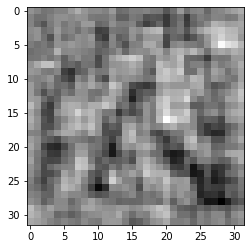

In [9]:
generator = make_generator_model()

noise = tf.random.normal([1, 64])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

# 판별자

In [11]:
# 판별자 model 생성
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)
discriminator.summary()

tf.Tensor([[0.00557957]], shape=(1, 1), dtype=float32)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 16, 16, 64)        1664      
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 16, 16, 64)        0         
                                                                 
 dropout_2 (Dropout)         (None, 16, 16, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 8, 128)         204928    
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 dropout_3 (Dropout)         (None, 8, 8, 128)         0         
                                                                 

### loss 값, optimizer 변수 구하기

In [12]:
EPOCHS = 38
noise_dim = 64
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [13]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [14]:
# 생성자 손실 값 리턴
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [15]:
# 판별자 손실 값 리턴 ( T 손실값+ F 손실값)
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [16]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### checkpoint, save img 

In [17]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [18]:
def generate_and_save_images(model, epoch, test_input):
    """
    모델이 이미지를 생성한 후 저장하는 함수입니다.
    
    Args:
        model: 이미지를 생성할 모델입니다.
        epoch: 진행 중인 Epoch 숫자입니다.
        test_input: model에 입력되는 데이터입니다.
    """

    # training=False 이면 모든 층이 추론(inference)모드로 진행됩니다.
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

### train

In [19]:
@tf.function
def train_step(images):
    """
    위에서 정의한 손실함수를 바탕으로
    Iteration(=step) 마다 가중치를 갱신합니다.

    Args:
        images: 훈련 데이터셋에 있는 실제 이미지입니다.
    """
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [20]:
def train(dataset, epochs=38) :

    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        # 이미지를 생성한 뒤 저장합니다.(추후에 만들 GIF를 위함입니다.)
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)

        # 15 에포크가 지날 때마다 모델을 Checkpoint에 저장합니다.
        if (epoch + 1) % 1 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
        
        # Epoch 마다 소요 시간을 출력합니다.
        print(f'Time for epoch {epoch + 1} is {time.time()-start} sec')

    # 마지막 에포크가 끝난 후 이미지를 생성합니다.
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

아래는 38 epoch까지 수행했을 때, 생성자가 만들어내는 이미지입니다.

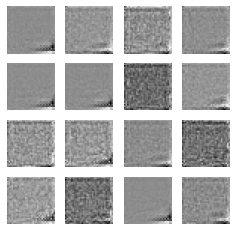

CPU times: user 1min 52s, sys: 11.9 s, total: 2min 4s
Wall time: 9min 47s


In [21]:
%%time
train(train_dataset, 5)  # epochs = 38

### img to gif

In [22]:
# 에포크 숫자를 사용하여 하나의 이미지를 보여줍니다.
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [23]:
# 위의 image를 gif 파일로 저장
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)

In [24]:
# colab일 때 파일 다운받기. 여기서는 dcgan.gif 파일
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download(anim_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>